In [1]:
import sys
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('data/raw/water_potability.csv')

In [3]:
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [13]:
def cast_types(df: pd.DataFrame) -> pd.DataFrame:
    for col, dtype in df.dtypes.items():
        if dtype == np.float64:
            df[col] = df[col].astype(np.float32)
        elif dtype == np.int64:
            df[col] = df[col].astype(np.int32)
    return df

In [14]:
def save_as_pickle(df: pd.DataFrame, path: str) -> None:
    df.to_pickle(path)

In [15]:
df = cast_types(df)
save_as_pickle(df, 'data/processed/water_potability.pkl')

# EDA

In [25]:
import seaborn as sns
from matplotlib import pyplot as plt

In [28]:
REAL_COLS = df.select_dtypes('float').columns.tolist()
TARGET = 'Potability'

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float32
 1   Hardness         3276 non-null   float32
 2   Solids           3276 non-null   float32
 3   Chloramines      3276 non-null   float32
 4   Sulfate          2495 non-null   float32
 5   Conductivity     3276 non-null   float32
 6   Organic_carbon   3276 non-null   float32
 7   Trihalomethanes  3114 non-null   float32
 8   Turbidity        3276 non-null   float32
 9   Potability       3276 non-null   int32  
dtypes: float32(9), int32(1)
memory usage: 128.1 KB


In [43]:
df.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080794,196.369507,22014.089844,7.122277,333.775787,426.205139,14.284970,66.396294,3.966786,0.390110
std,1.594319,32.879761,8768.570312,1.583085,41.416840,80.824066,3.308162,16.175009,0.780382,0.487849
min,0.000000,47.431999,320.942596,0.352000,129.000000,181.483749,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850540,15666.690186,6.127421,307.699493,365.734428,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967628,20927.833984,7.130299,333.073547,421.884964,14.218338,66.622482,3.955028,0.000000
75%,8.062066,216.667454,27332.761719,8.114887,359.950165,481.792313,16.557652,77.337479,4.500320,1.000000
max,14.000000,323.123993,61227.195312,13.127000,481.030640,753.342590,28.299999,124.000000,6.739000,1.000000


In [41]:
df[TARGET].sum() / len(df)

0.3901098901098901

<AxesSubplot:xlabel='ph'>

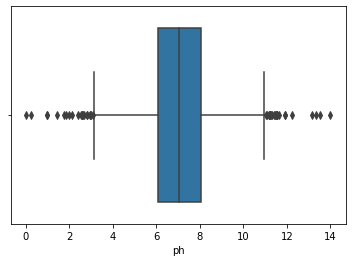

In [40]:
sns.boxplot(
    x=REAL_COLS[0],
    hue=TARGET,
    data=df
)

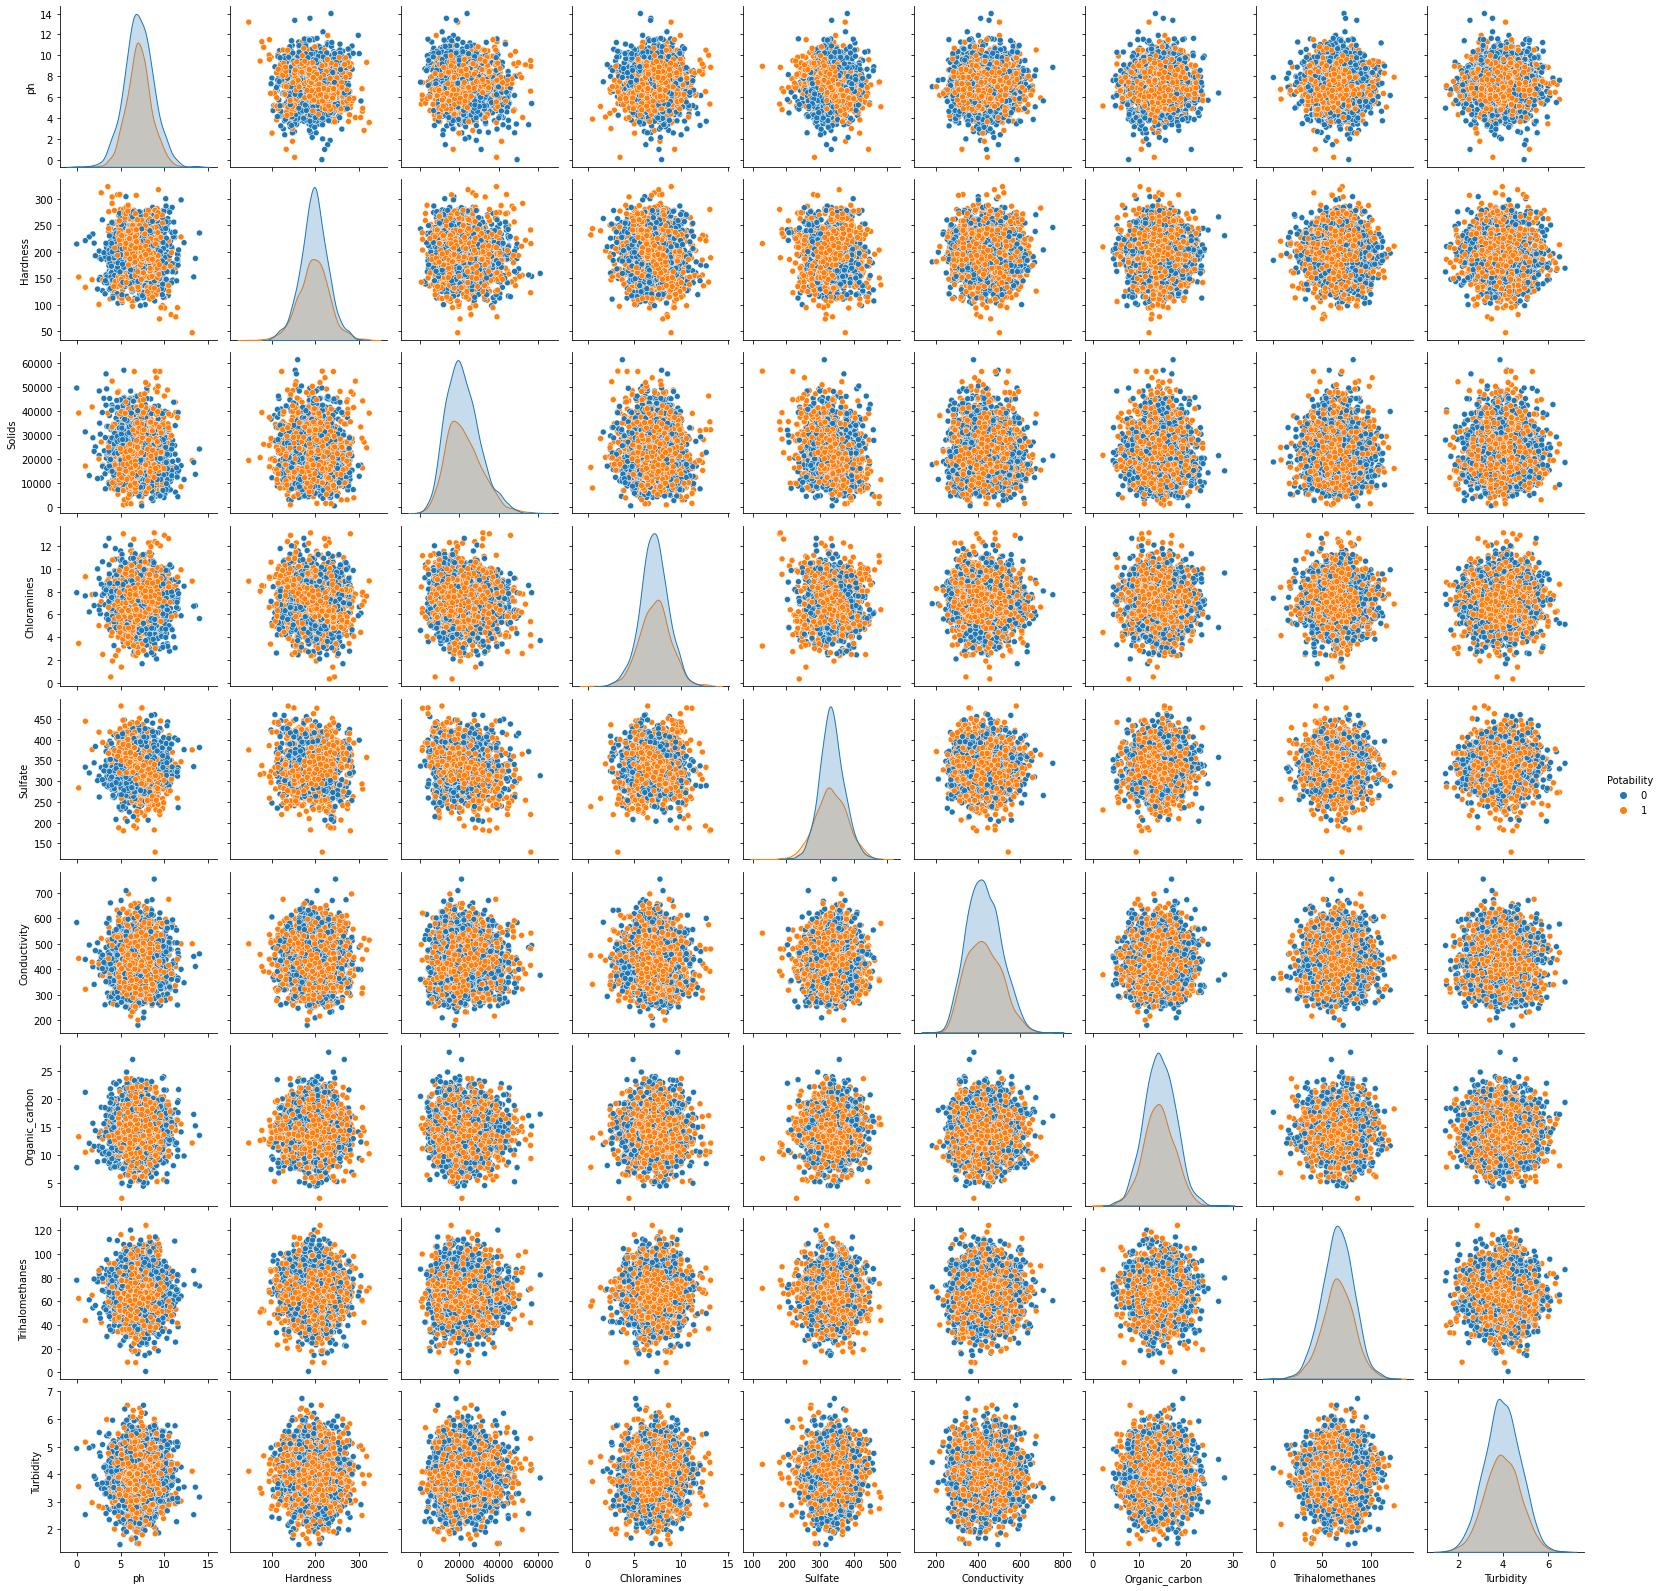

In [42]:
sns.pairplot(data=df, hue=TARGET)

MODELING

In [54]:
from sklearn.preprocessing import *
from sklearn.linear_model import *
from sklearn.pipeline import *
from sklearn.ensemble import *
from sklearn.impute import *
from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn.decomposition import *

In [58]:
preprocess_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler())
])
factorization_pipe = Pipeline(steps=[
    ('orig_processed_features', preprocess_pipe),
    ('svd', TruncatedSVD())
])

In [59]:
features = FeatureUnion(
    [
        ('orig_features', preprocess_pipe),
        ('factorization_features', factorization_pipe)
    ]
)

In [60]:
general_pip = Pipeline(steps=[
    ('preprocess_pipe', features),
    ('model', LogisticRegression())
])

In [61]:
cv_results = cross_val_score(
    X=df.drop(TARGET, axis=1),
    y=df[TARGET],
    cv=5,
    estimator=general_pip,
    scoring='roc_auc'
)

In [62]:
cv_results

array([0.51927734, 0.52162745, 0.53196078, 0.43084273, 0.49322525])